# Task 1: Convex hull in 2D

Below I will import the point cloud data, and compute the convex hull using four different methods: Graham scan, jarvis march, quickhull, and monotone chain.

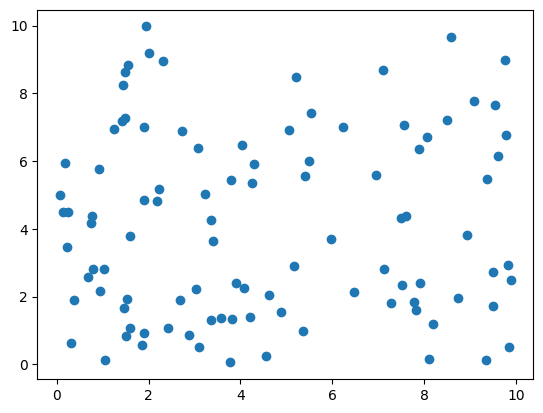

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the file
data = np.loadtxt('mesh.dat', skiprows=1)
X = data[:, 0]
Y = data[:, 1]
plt.scatter(X,Y)  



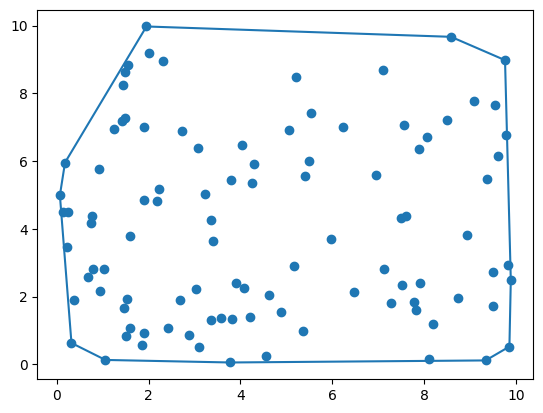

In [2]:
 #2D Graham scan 

def isCCW(v_a, v_b):
    crossprod = v_a[0]*v_b[1] - v_a[1]*v_b[0]
    return(crossprod>0)

def Grahamscan(data):
    Y = data[:, 1]
    ii = np.argmin(Y)        #find lowest y coordinate
    ipt = data[ii]
    length = len(data)
    angarr = np.zeros(length)
    for j in range(length):       #i'll take the dot product to represent an angle. a is the unit vector in x direction, b is displacement ot new pt
        a = [1,0]
        b = data[j]-ipt
        normb = np.sqrt(b[0]**2 + b[1]**2)
        if(j==ii):
            angarr[j] = -999
        else:
            angarr[j] = np.dot(a,b) / normb
    sort_indices = np.argsort(angarr)
    data_sorted = data[sort_indices]
    
    hull = []                           #data_sorted[0:3, :]   didn't do this since you can only append to lists
    for k in range(3):
        hull.append(data_sorted[k])    #adds first three points
        
    for i in range(3, length):
        cont=True
        while(cont):
            v_next = data_sorted[i]-hull[-1]
            v_prev = hull[-1]-hull[-2]
            if(isCCW(v_prev,v_next)):
                hull.pop()
                cont = True
            else:
                cont = False
                hull.append(data_sorted[i])
                
    
    hull.append(data_sorted[0]) #handles last step
    return hull
    

hull = np.array(Grahamscan(data))  #plots
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(X_f, Y_f)
plt.scatter(X,Y)    
    

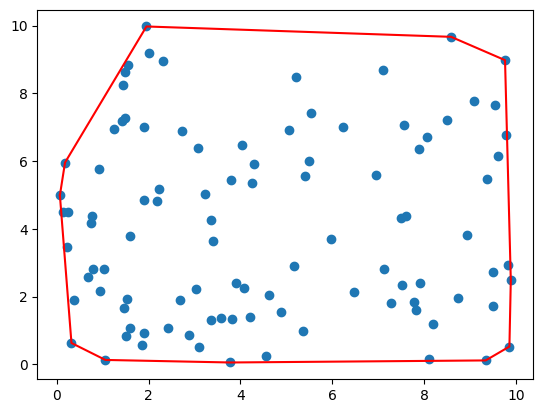

In [3]:
#Jarvis march


def orientation(p, q, r):     #returns 1 if CW, 2 if CCW
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])      #p is current point, q is next, r is next next
    if val == 0:
        return 0
    return 2 if val > 0 else 1

def jarvis_march(points):
    n = len(points)
    
    hull = []
    
    leftmost_idx = np.argmin(points[:, 0])
    p = leftmost_idx
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i
        
        p = q
        
        if p == leftmost_idx:  # Closed the loop
            break
    
    return np.array(hull)

# Compute the convex hull
hull = jarvis_march(data)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]), 'r-')  # Close the loop
plt.scatter(X, Y)
plt.show()

        

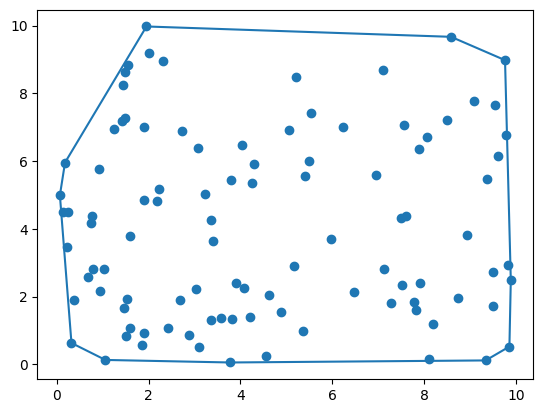

In [4]:
#quickhull


def triangle_area(p, q, r):
    return abs((q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])) / 2.0

def is_right_of_line(p, a, b):
    return (b[0] - a[0]) * (p[1] - a[1]) - (b[1] - a[1]) * (p[0] - a[0]) < 0

def quickhull_recursive(points, a, b, side):
    farthest_point = None
    max_area = 0
    
    # Find the point farthest from the line segment ab
    for p in points:
        if is_right_of_line(p, a, b) == side:
            area = triangle_area(a, b, p)
            if area > max_area:
                max_area = area
                farthest_point = p
    
    if farthest_point is None:  # Base case: no points on this side
        return [b]
    
    # Recursively find points on the farthest_point side of lines a-farthest_point and farthest_point-b
    left_of_ab = quickhull_recursive(points, a, farthest_point, side)
    right_of_ab = quickhull_recursive(points, farthest_point, b, side)
    
    return left_of_ab + [farthest_point] + right_of_ab

def quickhull(points):
    # Find the leftmost and rightmost points
    min_x_idx = np.argmin(points[:, 0])
    max_x_idx = np.argmax(points[:, 0])
    leftmost = points[min_x_idx]
    rightmost = points[max_x_idx]
    
    # Divide points into two subsets: above and below the line
    above = [p for p in points if is_right_of_line(p, leftmost, rightmost)]
    below = [p for p in points if is_right_of_line(p, rightmost, leftmost)]
    
    # Recursively find the convex hull points
    upper_hull = quickhull_recursive(above, leftmost, rightmost, True)
    lower_hull = quickhull_recursive(below, rightmost, leftmost, True)
    
    return [leftmost] + upper_hull + [rightmost] + lower_hull

# Compute the convex hull
hull = quickhull(data)

# Convert hull to a numpy array for easy plotting
hull = np.array(hull)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]))  # Close the loop
plt.scatter(X, Y)
plt.show()

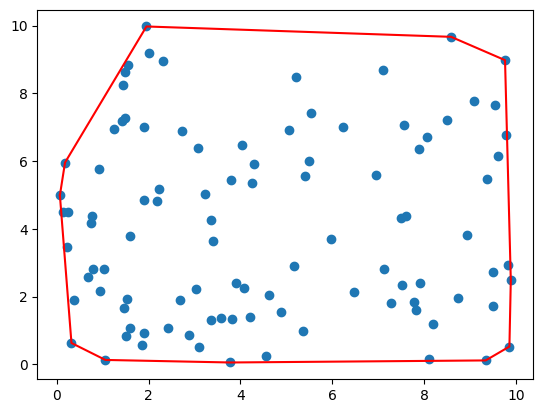

In [5]:
def monotone_chain(points):
    # Sort points
    points = sorted(points, key=lambda p: (p[0], p[1]))
    
    # Build the lower hull
    lower = []
    for p in points:
        while len(lower) >= 2 and orientation(lower[-2], lower[-1], p) != 2:  # Remove non-convex points
            lower.pop()
        lower.append(p)
    
    # Build the upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and orientation(upper[-2], upper[-1], p) != 2:  # Remove non-convex points
            upper.pop()
        upper.append(p)
    
    # Combine lower and upper hull, excluding the last point of each (it's repeated)
    return lower[:-1] + upper[:-1]

# Compute the convex hull
hull = monotone_chain(data)

# Convert hull to a numpy array for easy plotting
hull = np.array(hull)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]), 'r-')  # Close the loop
plt.scatter(X, Y)
plt.show()


#note, I used Chatgpt to help me with the last 3 algorithms


Now for the time complexity. I'll simply do a coupler iterations on different point clouds with each algorithm. Then I'll use the system time to record how long they take.

There may be some differences up to some constants (based on runtimes for different numpy commands etc), but the overall scaling as a function of N should be insightful.

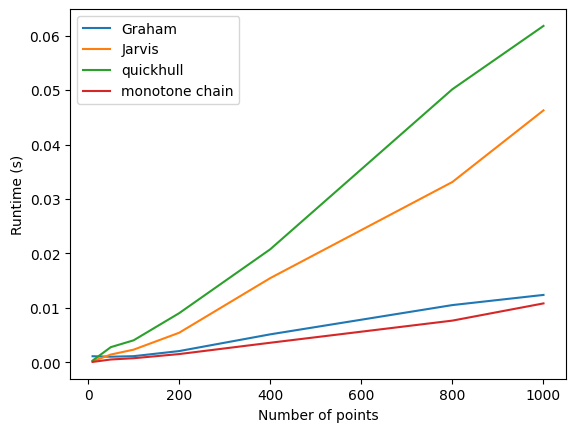

In [14]:
#now for time complexity
import time

def npointCloud(n):
    return np.random.rand(n,2)

G = []
J = []
Q = []
M = []



nvals = [10,50,100,200,400,800,1000]
for n in nvals:

    Gi = 0
    Ji = 0
    Qi = 0
    Mi = 0
    for i in range(10):
        d = npointCloud(n)


        start_time = time.time()
        h_G = Grahamscan(d)
        end_time = time.time()
        Gi += (end_time - start_time)

        start_time = time.time()
        h_J = jarvis_march(d)
        end_time = time.time()
        Ji += (end_time - start_time)

        start_time = time.time()
        h_Q = quickhull(d)
        end_time = time.time()
        Qi+=(end_time - start_time)

        start_time = time.time()
        h_M = monotone_chain(d)
        end_time = time.time()
        Mi += (end_time - start_time)

    G.append(Gi/10)
    J.append(Ji/10)
    Q.append(Qi/10)
    M.append(Mi/10)

plt.plot(nvals, G, label= 'Graham')
plt.plot(nvals, J, label= 'Jarvis')
plt.plot(nvals, Q, label= 'quickhull')
plt.plot(nvals, M, label= 'monotone chain')
plt.legend()
plt.xlabel('Number of points')
plt.ylabel('Runtime (s)')
plt.show()
    


    

From this plot, it seems all the methods scale somewhat linearly. This looks believable considering what I know that some of these algorithms are order nlog(n) or order nh. (h is number of points in final convex hull)

# c) 

Now doing the same thing, but just changing the bounds of the point cloud. I predict that this shouldn't have an effect.

I do predict that changing to a Gaussian distribution should matter. Essentially this means we likely need fewer points per n to create the hull.

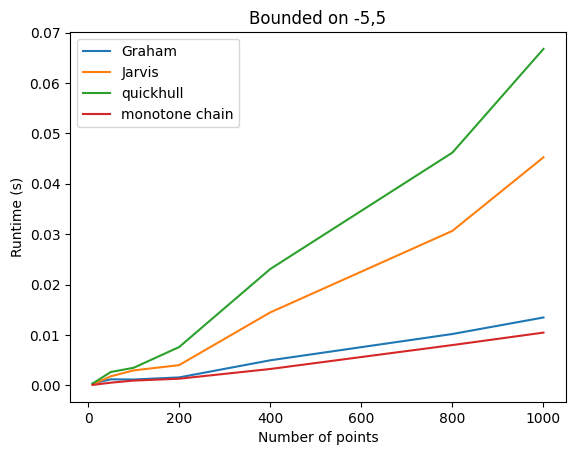

In [13]:
def npointCloud5(n):
    return np.random.rand(n,2) * 10 -5


G = []
J = []
Q = []
M = []
nvals = [10,50,100,200,400,800,1000]
for n in nvals:

    Gi = 0
    Ji = 0
    Qi = 0
    Mi = 0
    for i in range(10):
        d = npointCloud5(n)


        start_time = time.time()
        h_G = Grahamscan(d)
        end_time = time.time()
        Gi += (end_time - start_time)

        start_time = time.time()
        h_J = jarvis_march(d)
        end_time = time.time()
        Ji += (end_time - start_time)

        start_time = time.time()
        h_Q = quickhull(d)
        end_time = time.time()
        Qi+=(end_time - start_time)

        start_time = time.time()
        h_M = monotone_chain(d)
        end_time = time.time()
        Mi += (end_time - start_time)

    G.append(Gi/10)
    J.append(Ji/10)
    Q.append(Qi/10)
    M.append(Mi/10)

plt.plot(nvals, G, label= 'Graham')
plt.plot(nvals, J, label= 'Jarvis')
plt.plot(nvals, Q, label= 'quickhull')
plt.plot(nvals, M, label= 'monotone chain')
plt.legend()
plt.xlabel('Number of points')
plt.ylabel('Runtime (s)')
plt.title('Bounded on -5,5')
plt.show()

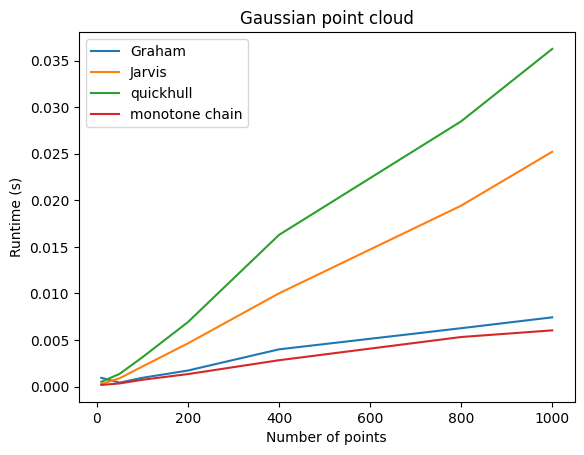

In [18]:
def npointCloudGauss(n):
    return np.random.normal(0,1, (n,2))

G = []
J = []
Q = []
M = []
nvals = [10,50,100,200,400,800,1000]
for n in nvals:

    Gi = 0
    Ji = 0
    Qi = 0
    Mi = 0
    for i in range(10):
        d = npointCloud5(n)


        start_time = time.time()
        h_G = Grahamscan(d)
        end_time = time.time()
        Gi += (end_time - start_time)

        start_time = time.time()
        h_J = jarvis_march(d)
        end_time = time.time()
        Ji += (end_time - start_time)

        start_time = time.time()
        h_Q = quickhull(d)
        end_time = time.time()
        Qi+=(end_time - start_time)

        start_time = time.time()
        h_M = monotone_chain(d)
        end_time = time.time()
        Mi += (end_time - start_time)

    G.append(Gi/10)
    J.append(Ji/10)
    Q.append(Qi/10)
    M.append(Mi/10)

plt.plot(nvals, G, label= 'Graham')
plt.plot(nvals, J, label= 'Jarvis')
plt.plot(nvals, Q, label= 'quickhull')
plt.plot(nvals, M, label= 'monotone chain')
plt.legend()
plt.xlabel('Number of points')
plt.ylabel('Runtime (s)')
plt.title('Gaussian point cloud')
plt.show()

# d)
Now plotting histograms.

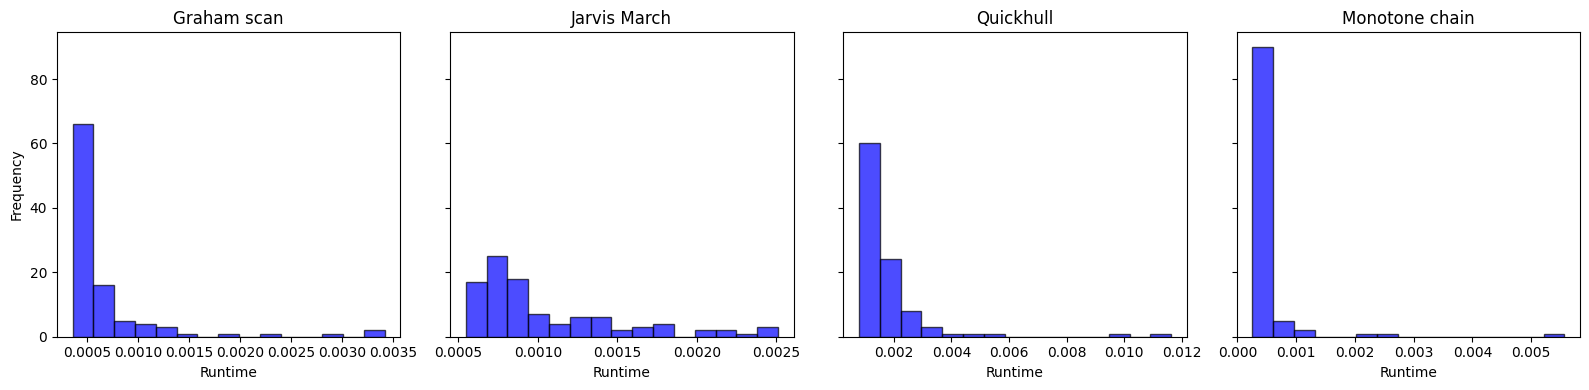

In [21]:
np.random.seed(13)

G = []
J = []
Q = []
M = []

for i in range(100):
    d = npointCloud(50)


    start_time = time.time()
    h_G = Grahamscan(d)
    end_time = time.time()
    G.append(end_time - start_time)

    start_time = time.time()
    h_J = jarvis_march(d)
    end_time = time.time()
    J.append(end_time - start_time)

    start_time = time.time()
    h_Q = quickhull(d)
    end_time = time.time()
    Q.append(end_time - start_time)

    start_time = time.time()
    h_M = monotone_chain(d)
    end_time = time.time()
    M.append(end_time - start_time)

titles = ["Graham scan", "Jarvis March", "Quickhull", "Monotone chain"]
datasets = [G, J, Q, M]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Plot histograms
for i, ax in enumerate(axes):
    ax.hist(datasets[i], bins=15, color='blue', alpha=0.7, edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel("Runtime")
    if i == 0:
        ax.set_ylabel("Frequency")

# Adjust layout and show plot
plt.tight_layout()
plt.show()



This agrees with my  results from earlier, with graham scan and monotone chain being much faster than jarvis march and quickhull. Jarvis march stands out among these histograms, it has a fairly spread out and even distribution of runtimes. I believe this is because Jarvis march has complexity O(nh), so it is very dependent on how many points end up being in the final hull. The other algorithms are essentially just taking the time average of a repeated process, so it makes sense it follows a distribution that looks more gaussian.